# **Process pseudobulks for subtype prediction**


You will run this 2 times, one for cellType pseudobulks and one for granular pseudobulks.
You can edit this in the parameters res_name and celltype_name


# **Imports**

In [1]:
# import the VAE code
import sys
from buddi import buddi
from buddi.preprocessing import sc_preprocess
from buddi.plotting import validation_plotting as vp


# general imports

import warnings
import numpy as np
import scanpy as sc
import anndata as ad
import scipy


# Images, plots, display, and visualization
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import scale, MinMaxScaler
from matplotlib_venn import venn2
from upsetplot import from_contents, UpSet

# programming stuff
import time
import os
import pickle
from pathlib import Path

# tensorflow stuff
import tensorflow as tf
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras.utils import to_categorical, normalize, plot_model


# disable eager execution
# https://github.com/tensorflow/tensorflow/issues/47311#issuecomment-786116401
from tensorflow.python.framework.ops import disable_eager_execution
disable_eager_execution()


2025-01-07 13:36:39.642466: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-01-07 13:36:39.642944: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 13:36:39.645203: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-01-07 13:36:39.651002: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1736282199.660536 2284181 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1736282199.66

In [2]:
## parameters
sc_aug_data_path = f"{os.getcwd()}/../../data/single_cell/GSE180661_pseudobulks/"


exp_id = "all-cellType" # cellType subtype granular

if exp_id == "all-cellType":
    res_id = "cellType" 
elif exp_id == "all-granular":
    res_id = "celltype_granular"
elif exp_id == "all_subtype":
    res_id = "subtype"


curr_treatment = "drug"
result_ad_file = f"{sc_aug_data_path}/{exp_id}.h5ad"


# **Load / Pre-process data**
Import pre-processed pseudobulks

In [3]:
# now get the sc ref training data

# read in order
# oritinal samples
#sample_order = ['Samp_2251', 'Samp_2293', 'Samp_2380', 'Samp_2467', 'Samp_2497']
sample_order = ['SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-115_S1_LEFT_ADNEXA',
                'SPECTRUM-OV-107_S1_BOWEL',
                'SPECTRUM-OV-110_S1_BOWEL',
                'SPECTRUM-OV-110_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-081_S1_RIGHT_ADNEXA',
                'SPECTRUM-OV-075_S1_LEFT_FALLOPIAN_TUBE',
                'SPECTRUM-OV-068_S1_LARGE_BOWEL',
                'SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY',
                'SPECTRUM-OV-009_S1_BOWEL',
                'SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-036_S1_LEFT_ADNEXA',
                'SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM',
                'SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM',
                'SPECTRUM-OV-053_S1_LEFT_OVARY',
                'SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM']


X_concat = None
Y_concat = None
meta_concat = None
for curr_samp in sample_order:

    print(curr_samp)
    pseudobulks_df, prop_df, gene_df, _, metadata_df = sc_preprocess.read_single_pseudobulk_file(sc_aug_data_path, curr_samp, "CTRL", "Train", exp_id)
    pseudobulks_df.columns = gene_df

    if X_concat is None:
        X_concat, Y_concat, meta_concat = pseudobulks_df, prop_df, metadata_df
    else:
        X_concat = pd.concat([X_concat, pseudobulks_df])
        Y_concat = pd.concat([Y_concat, prop_df])
        meta_concat = pd.concat([meta_concat, metadata_df])



SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-115_S1_LEFT_ADNEXA
SPECTRUM-OV-107_S1_BOWEL
SPECTRUM-OV-110_S1_BOWEL
SPECTRUM-OV-110_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-081_S1_RIGHT_ADNEXA
SPECTRUM-OV-075_S1_LEFT_FALLOPIAN_TUBE
SPECTRUM-OV-068_S1_LARGE_BOWEL
SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY
SPECTRUM-OV-009_S1_BOWEL
SPECTRUM-OV-036_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-036_S1_LEFT_ADNEXA
SPECTRUM-OV-053_S1_INFRACOLIC_OMENTUM
SPECTRUM-OV-053_S1_RIGHT_DIAPHRAGM
SPECTRUM-OV-053_S1_LEFT_OVARY
SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM


In [4]:
gene_df

gene_ids
AL627309.1    AL627309.1
AL627309.3    AL627309.3
AL627309.4    AL627309.4
AL732372.1    AL732372.1
AL669831.2    AL669831.2
                 ...    
AL354822.1    AL354822.1
AC004556.1    AC004556.1
AC233755.2    AC233755.2
AC233755.1    AC233755.1
AC240274.1    AC240274.1
Name: gene_ids, Length: 27152, dtype: object

In [5]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
1,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
2,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
3,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
4,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1695,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref
1696,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref
1697,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref
1698,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref


In [6]:
X_concat

gene_ids,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,...,MAFIP,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
0,1.0,0.0,0.0,0.0,0.0,14.0,0.0,7.0,5.0,0.0,...,2.0,9.0,10.0,1.0,0.0,14.0,0.0,40.0,1.0,2.0
0,1.0,0.0,0.0,0.0,0.0,21.0,0.0,4.0,2.0,0.0,...,5.0,7.0,18.0,4.0,0.0,13.0,0.0,125.0,3.0,4.0
0,1.0,0.0,1.0,0.0,0.0,20.0,1.0,8.0,3.0,0.0,...,7.0,9.0,11.0,1.0,0.0,18.0,0.0,0.0,0.0,6.0
0,1.0,0.0,0.0,0.0,0.0,16.0,1.0,4.0,2.0,0.0,...,3.0,5.0,11.0,2.0,0.0,20.0,0.0,103.0,2.0,12.0
0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,5.0,2.0,0.0,...,2.0,10.0,3.0,0.0,0.0,22.0,0.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,31.0,2.0,1.0,1.0,0.0,...,6.0,0.0,16.0,1.0,0.0,1.0,0.0,0.0,9.0,1.0
0,1.0,0.0,0.0,0.0,0.0,29.0,2.0,5.0,0.0,0.0,...,4.0,0.0,15.0,0.0,0.0,2.0,0.0,0.0,8.0,0.0
0,0.0,0.0,0.0,0.0,0.0,23.0,1.0,3.0,1.0,0.0,...,10.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0,11.0,2.0
0,0.0,0.0,0.0,0.0,0.0,30.0,1.0,3.0,2.0,0.0,...,4.0,1.0,11.0,0.0,0.0,1.0,0.0,0.0,21.0,2.0


In [7]:
# double check all the pseudobulks/bulks were read in
meta_concat.sample_id.value_counts()

SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM                                  1700
SPECTRUM-OV-115_S1_LEFT_ADNEXA                                         1700
SPECTRUM-OV-107_S1_BOWEL                                               1700
SPECTRUM-OV-110_S1_BOWEL                                               1700
SPECTRUM-OV-110_S1_INFRACOLIC_OMENTUM                                  1700
SPECTRUM-OV-083_S1_INFRACOLIC_OMENTUM                                  1700
SPECTRUM-OV-081_S1_INFRACOLIC_OMENTUM                                  1700
SPECTRUM-OV-081_S1_RIGHT_ADNEXA                                        1700
SPECTRUM-OV-075_S1_LEFT_FALLOPIAN_TUBE                                 1700
SPECTRUM-OV-068_S1_LARGE_BOWEL                                         1700
SPECTRUM-OV-065_S1_INFRACOLIC_OMENTUM                                  1700
SPECTRUM-OV-024_S1_INFRACOLIC_OMENTUM                                  1700
SPECTRUM-OV-008_S1_LEFT_PARARENAL_LYMPH_NODE_WITH_COLONIC_MESENTARY    1700
SPECTRUM-OV-

In [8]:
Y_concat

,Ovarian.cancer.cell,Fibroblast,Endothelial.cell,Monocyte,T.cell,B.cell,Plasma.cell
0,0.215000,0.010000,0.260000,0.045000,0.215000,0.175000,0.080000
0,0.030000,0.100000,0.030000,0.270000,0.020000,0.330000,0.220000
0,0.380000,0.090000,0.025000,0.210000,0.045000,0.240000,0.010000
0,0.020000,0.435000,0.165000,0.115000,0.070000,0.005000,0.190000
0,0.585000,0.220000,0.060000,0.015000,0.085000,0.030000,0.005000
...,...,...,...,...,...,...,...
0,0.008510,0.000712,0.009851,0.005425,0.003097,0.002376,0.970029
0,0.005479,0.028999,0.008132,0.002173,0.015892,0.016113,0.923213
0,0.003576,0.005394,0.004032,0.001560,0.017317,0.008581,0.959540
0,0.018103,0.013037,0.034055,0.012250,0.081302,0.013003,0.828250


# Plot all data

In [9]:
meta_concat

,sample_id,stim,isTraining,cell_prop_type,samp_type
0,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
1,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
2,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
3,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
4,SPECTRUM-OV-115_S1_INFRACOLIC_OMENTUM,CTRL,Train,random,sc_ref
...,...,...,...,...,...
1695,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref
1696,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref
1697,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref
1698,SPECTRUM-OV-049_S1_INFRACOLIC_OMENTUM,CTRL,Train,cell_type_specific,sc_ref


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/sklearn/manifold/_t_sne.py:1164: FutureWarning: 'n_iter' was renamed to 'max_iter' in version 1.5 and will be removed in 1.7.
  warnings.warn(


[t-SNE] Computing 61 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.045s...
[t-SNE] Computed neighbors for 1000 samples in 0.229s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 17773.418344
[t-SNE] KL divergence after 250 iterations with early exaggeration: 64.208351
[t-SNE] KL divergence after 500 iterations: 0.778058
(1000, 2)
(1000, 2)


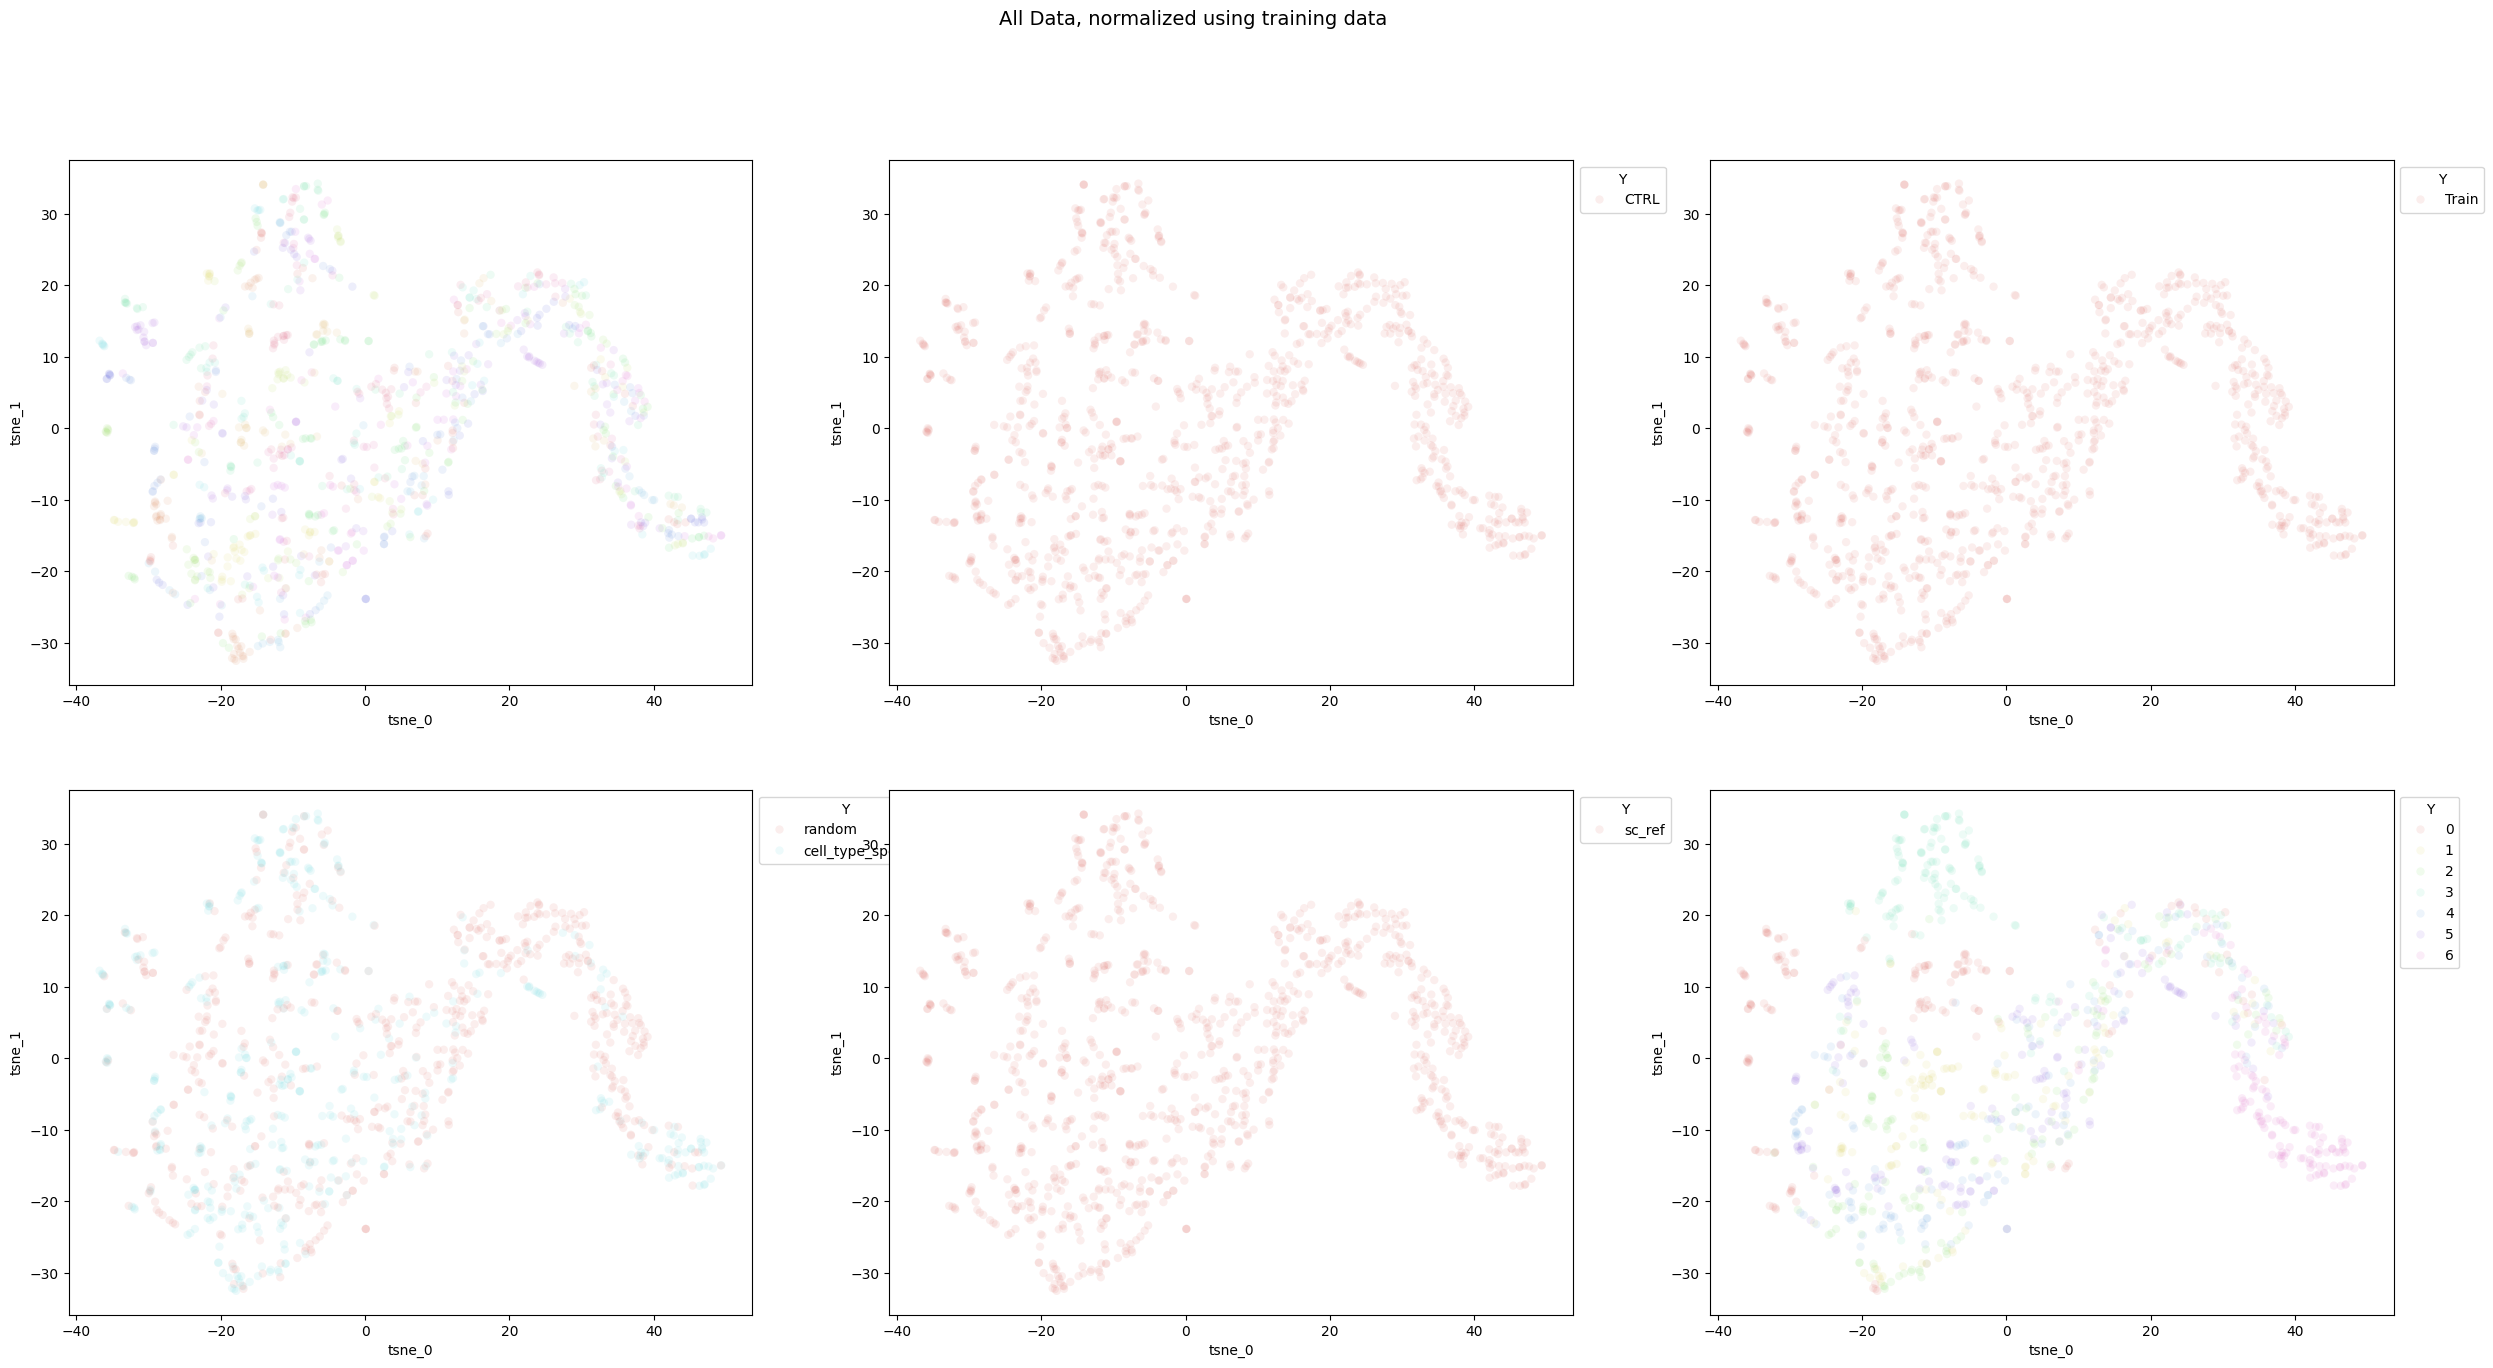

In [10]:
## plot samples
idx_tmp = np.random.choice(range(X_concat.shape[0]), 1000, replace=True)


plot_df = vp.get_tsne_for_plotting(X_concat.iloc[idx_tmp])

fig, axs = plt.subplots(2, 3, figsize=(30,15))

Y_temp = np.copy(Y_concat.iloc[idx_tmp])
Y_temp = np.argmax(Y_temp, axis=1) 

vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].sample_id.to_numpy(), axs[0,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].stim.to_numpy(), axs[0,1], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].isTraining.to_numpy(), axs[0,2], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].cell_prop_type.to_numpy(), axs[1,0], title=f"")
vp.plot_tsne(plot_df, meta_concat.iloc[idx_tmp].samp_type.to_numpy(), axs[1,1], title=f"")
vp.plot_tsne(plot_df, Y_temp, axs[1,2], title=f"")


fig.suptitle("All Data, normalized using training data", fontsize=14)

axs[0,0].legend([],[], frameon=False)

fig.show()


In [11]:
Y_concat

,Ovarian.cancer.cell,Fibroblast,Endothelial.cell,Monocyte,T.cell,B.cell,Plasma.cell
0,0.215000,0.010000,0.260000,0.045000,0.215000,0.175000,0.080000
0,0.030000,0.100000,0.030000,0.270000,0.020000,0.330000,0.220000
0,0.380000,0.090000,0.025000,0.210000,0.045000,0.240000,0.010000
0,0.020000,0.435000,0.165000,0.115000,0.070000,0.005000,0.190000
0,0.585000,0.220000,0.060000,0.015000,0.085000,0.030000,0.005000
...,...,...,...,...,...,...,...
0,0.008510,0.000712,0.009851,0.005425,0.003097,0.002376,0.970029
0,0.005479,0.028999,0.008132,0.002173,0.015892,0.016113,0.923213
0,0.003576,0.005394,0.004032,0.001560,0.017317,0.008581,0.959540
0,0.018103,0.013037,0.034055,0.012250,0.081302,0.013003,0.828250


In [12]:
X_concat

gene_ids,AL627309.1,AL627309.3,AL627309.4,AL732372.1,AL669831.2,AL669831.5,FAM87B,LINC00115,FAM41C,AL645608.7,...,MAFIP,AC011043.1,AL592183.1,AC007325.4,AC007325.2,AL354822.1,AC004556.1,AC233755.2,AC233755.1,AC240274.1
0,1.0,0.0,0.0,0.0,0.0,14.0,0.0,7.0,5.0,0.0,...,2.0,9.0,10.0,1.0,0.0,14.0,0.0,40.0,1.0,2.0
0,1.0,0.0,0.0,0.0,0.0,21.0,0.0,4.0,2.0,0.0,...,5.0,7.0,18.0,4.0,0.0,13.0,0.0,125.0,3.0,4.0
0,1.0,0.0,1.0,0.0,0.0,20.0,1.0,8.0,3.0,0.0,...,7.0,9.0,11.0,1.0,0.0,18.0,0.0,0.0,0.0,6.0
0,1.0,0.0,0.0,0.0,0.0,16.0,1.0,4.0,2.0,0.0,...,3.0,5.0,11.0,2.0,0.0,20.0,0.0,103.0,2.0,12.0
0,0.0,0.0,0.0,0.0,0.0,17.0,0.0,5.0,2.0,0.0,...,2.0,10.0,3.0,0.0,0.0,22.0,0.0,1.0,0.0,3.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0,0.0,0.0,0.0,0.0,0.0,31.0,2.0,1.0,1.0,0.0,...,6.0,0.0,16.0,1.0,0.0,1.0,0.0,0.0,9.0,1.0
0,1.0,0.0,0.0,0.0,0.0,29.0,2.0,5.0,0.0,0.0,...,4.0,0.0,15.0,0.0,0.0,2.0,0.0,0.0,8.0,0.0
0,0.0,0.0,0.0,0.0,0.0,23.0,1.0,3.0,1.0,0.0,...,10.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0,11.0,2.0
0,0.0,0.0,0.0,0.0,0.0,30.0,1.0,3.0,2.0,0.0,...,4.0,1.0,11.0,0.0,0.0,1.0,0.0,0.0,21.0,2.0


In [13]:
pd.DataFrame(gene_df)

,gene_ids
gene_ids,
AL627309.1,AL627309.1
AL627309.3,AL627309.3
AL627309.4,AL627309.4
AL732372.1,AL732372.1
AL669831.2,AL669831.2
...,...
AL354822.1,AL354822.1
AC004556.1,AC004556.1
AC233755.2,AC233755.2


In [14]:
result_ad_file_tsv = f"{sc_aug_data_path}/{exp_id}.tsv"
X_concat.to_csv(result_ad_file_tsv, sep="\t")

In [15]:
result_ad_file

'/var/projects/proportion_subtype_predictor/code/2_format_write_pseudobulk/../../data/single_cell/GSE180661_pseudobulks//all-cellType.h5ad'

In [16]:

# make anndata

# write out anndata for R to run consensusOV

meta_concat.index = range(0,meta_concat.shape[0])
Y_concat.index = meta_concat.index
X_concat.index = meta_concat.index
X_concat.columns

full_meta = pd.concat([meta_concat, Y_concat], axis=1)

adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))

adata.write(result_ad_file)

adata

/tmp/ipykernel_2284181/4003203352.py:12: FutureWarning: X.dtype being converted to np.float32 from float64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  adata = ad.AnnData(X=X_concat, obs=full_meta, var=pd.DataFrame(gene_df))


/var/projects/proportion_subtype_predictor/.prop_subtype_venv/lib/python3.12/site-packages/anndata/_core/anndata.py:121: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


AnnData object with n_obs × n_vars = 34000 × 27152
    obs: 'sample_id', 'stim', 'isTraining', 'cell_prop_type', 'samp_type', 'Ovarian.cancer.cell', 'Fibroblast', 'Endothelial.cell', 'Monocyte', 'T.cell', 'B.cell', 'Plasma.cell'
    var: 'gene_ids'